# Data Ingestion - Repurposing Data Sources

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R 
library(imager)
library(tidyverse)
library(rvest)

## Web Scraping

### HTML Tables

In [3]:
# Same string composed over two lines for layout
# XXXX substituted for actual ID because of discussed breakage
url2009 = ("https://en.wikipedia.org/w/index.php?"
           "title=2009_flu_pandemic&oldid=XXXX")

### Non-Tabular Data

In [4]:
url_http = ("https://en.wikipedia.org/w/index.php?"
            "title=List_of_HTTP_status_codes&oldid=947767948")

In [5]:
import requests
resp = requests.get(url_http)
resp.status_code

200

In [6]:
pprint(resp.content[43400:44000], width=55)

(b'e_ref-44" class="reference"><a href="#cite_note-'
 b'44">&#91;43&#93;</a></sup></dd>\n<dt><span class='
 b'"anchor" id="412"></span>412 Precondition Failed'
 b' (<a class="external mw-magiclink-rfc" rel="nofo'
 b'llow" href="https://tools.ietf.org/html/rfc7232"'
 b'>RFC 7232</a>)</dt>\n<dd>The server does not meet'
 b' one of the preconditions that the requester put'
 b' on the request header fields.<sup id="cite_ref-'
 b'45" class="reference"><a href="#cite_note-45">&#'
 b'91;44&#93;</a></sup><sup id="cite_ref-46" class='
 b'"reference"><a href="#cite_note-46">&#91;45&#93;'
 b'</a></sup></dd>\n<dt><span class="anchor" id="413'
 b'"></span>413 Payload Too')


In [7]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(resp.content)

In [8]:
codes = soup.find_all('dt')
for code in codes[:5] + codes[-5:]:
    print(code.text)

100 Continue
101 Switching Protocols
102 Processing (WebDAV; RFC 2518)
103 Early Hints (RFC 8297)
200 OK
524 A Timeout Occurred
525 SSL Handshake Failed
526 Invalid SSL Certificate
527 Railgun Error
530


In [9]:
def find_dds_after(node):
    dds = []
    sib = node.next_sibling
    while True:     # Loop until a break
        # Last sibling within page section
        if sib is None:
            break
        # Text nodes have no element name
        elif not sib.name: 
            sib = sib.next_sibling
            continue
        # A definition node
        if sib.name == 'dd':
            dds.append(sib)
            sib = sib.next_sibling
        # Finished <dd> the definition nodes
        else:
            break
    return dds

In [10]:
for code in codes[23:26]:
    print(code.text)
    for dd in find_dds_after(code):
        print("  ", dd.text[:40], "...")    

400 Bad Request
   The server cannot or will not process th ...
401 Unauthorized (RFC 7235)
   Similar to 403 Forbidden, but specifical ...
   Note: Some sites incorrectly issue HTTP  ...
402 Payment Required
   Reserved for future use. The original in ...


In [11]:
data = []
for code in codes:
    # All codes are 3 character numbers
    number = code.text[:3]
    # parenthetical is not part of status
    text, note = code.text[4:], ""
    if " (" in text:
        text, note = text.split(" (")
        note = note.rstrip(")")
    # Compose description from list of strings
    description = "\n".join(t.text for t in find_dds_after(code))
    data.append([int(number), text, note, description])

In [12]:
(pd.DataFrame(data, 
              columns=["Code", "Text", "Note", "Description"])
    .set_index('Code')
    .sort_index()
    .head(8))

,Text,Note,Description
Code,,,
100,Continue,,The server has received the request headers an...
101,Switching Protocols,,The requester has asked the server to switch p...
102,Processing,WebDAV; RFC 2518,A WebDAV request may contain many sub-requests...
103,Checkpoint,,Used in the resumable requests proposal to res...
103,Early Hints,RFC 8297,Used to return some response headers before fi...
200,OK,,Standard response for successful HTTP requests...
201,Created,,"The request has been fulfilled, resulting in t..."
202,Accepted,,"The request has been accepted for processing, ..."


### Command-Line Scraping

In [13]:
%%bash
base='https://en.wikipedia.org/w/index.php?title='
url="$base"'List_of_HTTP_status_codes&oldid=947767948'
lynx -dump $url | sed -n '397,406p'

          requester put on the request header fields.^[170][44]^[171][45]

   413 Payload Too Large ([172]RFC 7231)
          The request is larger than the server is willing or able to
          process. Previously called "Request Entity Too Large".^[173][46]

   414 URI Too Long ([174]RFC 7231)
          The [175]URI provided was too long for the server to process.
          Often the result of too much data being encoded as a
          query-string of a GET request, in which case it should be


In [14]:
%%bash
base='https://en.wikipedia.org/w/index.php?title='
url="$base"'List_of_HTTP_status_codes&oldid=947767948'
links -dump $url | sed -n '377,385p'

           requester put on the request header fields.^[44]^[45]

   413 Payload Too Large (RFC 7231)
           The request is larger than the server is willing or able to
           process. Previously called "Request Entity Too Large".^[46]

   414 URI Too Long (RFC 7231)
           The URI provided was too long for the server to process. Often the
           result of too much data being encoded as a query-string of a GET


## Portable Document Format

In [15]:
%%bash
tabula -g -t -p5 data/Preface-snapshot.pdf

[1]:,,Last_Name,First_Name,Favorite_Color,Age
"",Student_No,,,,
"",1,Johnson,Mia,periwinkle,12.0
"",2,Lopez,Liam,blue-green,13.0
"",3,Lee,Isabella,<missing>,11.0
"",4,Fisher,Mason,gray,NaN
"",5,Gupta,Olivia,sepia,NaN
"",6,Robinson,Sophia,blue,12.0


In [16]:
%%bash
tabula -a'%72,13,90,100' -fTSV -p5 data/Preface-snapshot.pdf

First	Last	Age
<chr>	<chr>	
bl>		
Mia	Johnson	12
Liam	Lopez	13
Isabella	Lee	11
Mason	Fisher	NaN
Olivia	Gupta	NaN
Sophia	Robinson	12


In [17]:
%%bash
tabula -p7 -a'120,0,220,500' data/Preface-snapshot.pdf 

Number,Color,Number,Color
1,beige,6,alabaster
2,eggshell,7,sandcastle
3,seafoam,8,chartreuse
4,mint,9,sepia
5,cream,10,lemon


In [18]:
%%bash
# Start with page 7, tool writes to .txt file 
# Use layout mode to preserve horizontal position
pdftotext -f 7 -layout data/Preface-snapshot.pdf
# Remove 25 spaces from start of lines
# Wrap other lines that are too wide
sed -E 's/^ {,25}//' data/Preface-snapshot.txt |
    fmt -s | 
    head -20

• Missing data in the Favorite Color field should be substituted with
the string <missing>.
• Student ages should be between 9 and 14, and all other values are
considered missing data.
• Some colors are numerically coded, but should be dealiased. The
mapping is:

   Number     Color      Number    Color
      1       beige          6     alabaster
      2       eggshell       7     sandcastle
      3       seafoam        8     chartreuse
      4       mint           9     sepia
      5       cream          10    lemon


Using the small test data set is a good way to test your code. But try
also manually adding more
rows with similar, or different, problems in them, and see how well your
code produces a reasonable
result.


## Image Formats

In [19]:
from PIL import Image, ImageOps

for fname in glob('img/*'):
    try:
        with Image.open(fname) as im:
            print(fname, im.format, "%dx%d" % im.size, im.mode)
    except IOError:
        pass

img/(Ch03)Luminance values in Confucius drawing.png PNG 2000x2000 P
img/Flu2009-infobox.png PNG 607x702 RGBA
img/Konfuzius-1770.jpg JPEG 566x800 RGB
img/UMAP.png PNG 2400x2400 RGBA
img/(Ch02)108 ratings.png PNG 3600x2400 RGBA
img/DQM-with-Lenin-Minsk.jpg MPO 3240x4320 RGB
img/(Ch02)Counties of the United States.png PNG 4800x3000 RGBA
img/PCA Components.png PNG 3600x2400 RGBA
img/(Ch01)Student score by year.png PNG 3600x2400 RGBA
img/HDFCompass.png PNG 958x845 RGBA
img/(Ch01)Visitors per station (max 32767).png PNG 3600x2400 RGBA
img/t-SNE.png PNG 4800x4800 RGBA
img/dog_cat.png PNG 6000x6000 RGBA
img/Parameter space for two features.png PNG 3600x2400 RGBA
img/Whitened Components.png PNG 3600x2400 RGBA
img/(Ch01)Lengths of Station Names.png PNG 3600x2400 RGBA
img/preface-2.png PNG 945x427 RGBA
img/DQM-with-Lenin-Minsk.jpg_original MPO 3240x4320 RGB
img/PCA.png PNG 4800x4800 RGBA
img/Excel-Pitfalls.png PNG 551x357 RGBA
img/gnosis-traffic.png PNG 1064x1033 RGBA
img/Film_Awards.png PNG 1587

Image. Width: 566 pix Height: 800 pix Depth: 1 Colour channels: 3 


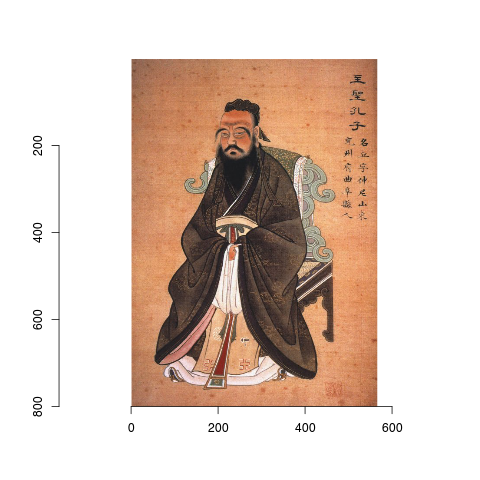

In [20]:
%%R
library(imager)
confucius <- load.image("img/Konfuzius-1770.jpg")
print(confucius)
plot(confucius)

### Pixel Statistics

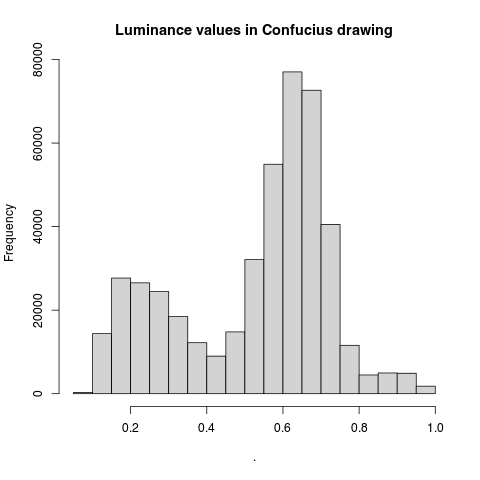

In [21]:
%%R
grayscale(confucius) %>% 
    hist(main="Luminance values in Confucius drawing") 

In [22]:
%%R
# Save histogram to disk
png("img/(Ch03)Luminance values in Confucius drawing.png", width=1200)
grayscale(confucius) %>% 
    hist(main="Luminance values in Confucius drawing") 

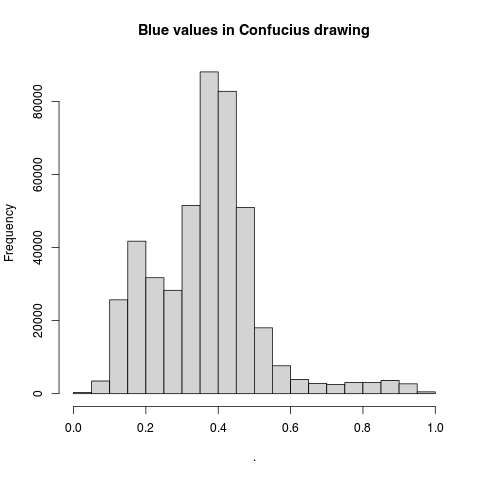

In [23]:
%%R
B(confucius) %>% 
    hist(main="Blue values in Confucius drawing")

In [24]:
%%R
# Save histogram to disk
png("img/(Ch03)Blue values in Confucius drawing.png", width=1200)
B(confucius) %>% 
    hist(main="Blue values in Confucius drawing")

In [25]:
%%R
data <- as.data.frame(confucius) %>%
    as_tibble %>%
    # channels 1, 2, 3 (RGB) as factor
    mutate(cc = as.factor(cc))
data

# A tibble: 1,358,400 x 4
       x     y cc    value
   <int> <int> <fct> <dbl>
 1     1     1 1     0.518
 2     2     1 1     0.529
 3     3     1 1     0.518
 4     4     1 1     0.510
 5     5     1 1     0.533
 6     6     1 1     0.541
 7     7     1 1     0.533
 8     8     1 1     0.533
 9     9     1 1     0.510
10    10     1 1     0.471
# … with 1,358,390 more rows


In [26]:
# Courtesy name: Zhòngní (仲尼)
# "Kǒng Fūzǐ" (孔夫子) was coined by 16th century Jesuits
仲尼 = Image.open('img/Konfuzius-1770.jpg')
data = np.array(仲尼)
print("Image shape:", data.shape)
print("Some values\n", data[:2, :, :])

Image shape: (800, 566, 3)
Some values
 [[[132  91  69]
  [135  94  74]
  [132  91  71]
  ...
  [148  98  73]
  [142  95  69]
  [135  89  63]]

 [[131  90  68]
  [138  97  75]
  [139  98  78]
  ...
  [147 100  74]
  [144  97  71]
  [138  92  66]]]


### Channel Manipulation

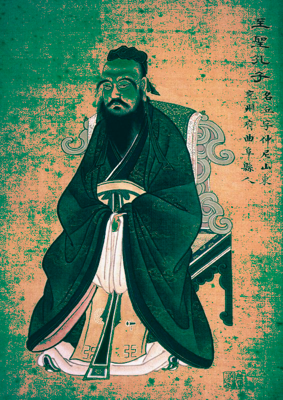

In [27]:
# split the Confucius image into individual bands
source = 仲尼.split()
R, G, B = 0, 1, 2

# select regions where blue is less than 100
mask = source[B].point(lambda i: 255 if i < 100 else 0)
source[R].paste(0, None, mask)
im = Image.merge(仲尼.mode, source)
im.save('img/(Ch03)Konfuzius-bluefilter.jpg')
ImageOps.scale(im, 0.5)

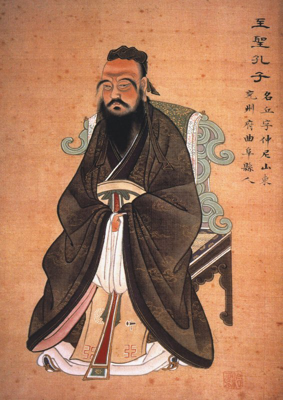

In [28]:
ImageOps.scale(仲尼, 0.5)

In [29]:
%%R
confucius.hsv <- RGBtoHSL(confucius)
data <- as.data.frame(confucius.hsv) %>%
    as_tibble %>%
    # channels 1, 2, 3 (HSV) as factor
    mutate(cc = as.factor(cc))
data 

# A tibble: 1,358,400 x 4
       x     y cc    value
   <int> <int> <fct> <dbl>
 1     1     1 1      21.0
 2     2     1 1      19.7
 3     3     1 1      19.7
 4     4     1 1      19.7
 5     5     1 1      19.7
 6     6     1 1      19.7
 7     7     1 1      19.7
 8     8     1 1      19.7
 9     9     1 1      19.7
10    10     1 1      20  
# … with 1,358,390 more rows


In [30]:
%%R
data %>% 
    mutate(cc = recode(
        cc, `1`="Hue", `2`="Saturation", `3`="Value")) %>%
    group_by(cc) %>%
    summarize(Mean = mean(value), SD = sd(value))

`summarise()` ungrouping output (override with `.groups` argument)
# A tibble: 3 x 3
  cc           Mean     SD
  <fct>       <dbl>  <dbl>
1 Hue        34.5   59.1  
2 Saturation  0.448  0.219
3 Value       0.521  0.192


### Metadata

In [31]:
from PIL.ExifTags import TAGS

def get_exif(img):
    txtdata, bindata = dict(), dict()
    for tag_id in (exifdata := img.getexif()):
        # Lookup tag name from tag_id if available
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        if isinstance(data, bytes):
            bindata[tag] = data
        else:
            txtdata[tag] = data
    return txtdata, bindata

In [32]:
get_exif(仲尼)  # Zhòngní, i.e. Confucius

({}, {})

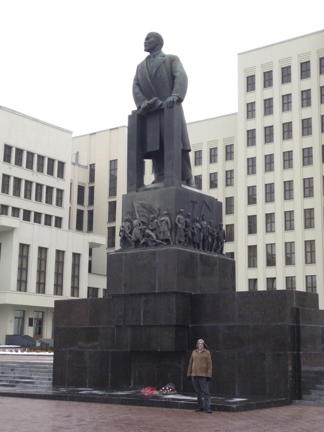

In [33]:
# Could continue using multi-lingual variable names by
# choosing `Ленин`, `Ульянов` or `Мінск`
dqm = Image.open('img/DQM-with-Lenin-Minsk.jpg')
ImageOps.scale(dqm, 0.1)

In [34]:
txtdata, bindata = get_exif(dqm)
txtdata

{'CompressedBitsPerPixel': 4.0,
 'DateTimeOriginal': '2015:02:01 13:01:53',
 'DateTimeDigitized': '2015:02:01 13:01:53',
 'ExposureBiasValue': 0.0,
 'MaxApertureValue': 4.2734375,
 'MeteringMode': 5,
 'LightSource': 0,
 'Flash': 16,
 'FocalLength': 10.0,
 'ColorSpace': 1,
 'ExifImageWidth': 3240,
 'ExifInteroperabilityOffset': 10564,
 'FocalLengthIn35mmFilm': 56,
 'SceneCaptureType': 0,
 'ExifImageHeight': 4320,
 'Contrast': 0,
 'Saturation': 0,
 'Sharpness': 0,
 'Make': 'Panasonic',
 'Model': 'DMC-FH4',
 'Orientation': 1,
 'SensingMethod': 2,
 'YCbCrPositioning': 2,
 'ExposureTime': 0.00625,
 'XResolution': 180.0,
 'YResolution': 180.0,
 'FNumber': 4.4,
 'ExposureProgram': 2,
 'CustomRendered': 0,
 'ISOSpeedRatings': 500,
 'ResolutionUnit': 2,
 'ExposureMode': 0,
 34864: 1,
 'WhiteBalance': 0,
 'Software': 'Ver.1.0  ',
 'DateTime': '2015:02:01 13:01:53',
 'DigitalZoomRatio': 0.0,
 'GainControl': 2,
 'ExifOffset': 634}

In [35]:
bindata['ExifVersion'].decode('ascii')

'0230'

In [36]:
def components(cc):
    colors = {0: None,
              1: 'Y', 2: 'Cb', 3: 'Cr',
              4: 'R', 5: 'G', 6: 'B'}
    return [colors.get(c, 'reserved') for c in cc]

In [37]:
components(bindata['ComponentsConfiguration'])

['Y', 'Cb', 'Cr', None]

## Binary Serialized Data Structures

In [38]:
arr = np.load(open('data/binary-3d.npy', 'rb'))
print(arr, '\n', arr.shape, arr.dtype)

[[[ 0.  1.  2.]
  [ 3.  4.  5.]]

 [[ 6.  7.  8.]
  [ 9. 10. 11.]]] 
 (2, 2, 3) float64


In [39]:
%%bash
hexdump -Cv data/binary-3d.npy

00000000  93 4e 55 4d 50 59 01 00  76 00 7b 27 64 65 73 63  |.NUMPY..v.{'desc|
00000010  72 27 3a 20 27 3c 66 38  27 2c 20 27 66 6f 72 74  |r': '<f8', 'fort|
00000020  72 61 6e 5f 6f 72 64 65  72 27 3a 20 46 61 6c 73  |ran_order': Fals|
00000030  65 2c 20 27 73 68 61 70  65 27 3a 20 28 32 2c 20  |e, 'shape': (2, |
00000040  32 2c 20 33 29 2c 20 7d  20 20 20 20 20 20 20 20  |2, 3), }        |
00000050  20 20 20 20 20 20 20 20  20 20 20 20 20 20 20 20  |                |
00000060  20 20 20 20 20 20 20 20  20 20 20 20 20 20 20 20  |                |
00000070  20 20 20 20 20 20 20 20  20 20 20 20 20 20 20 0a  |               .|
00000080  00 00 00 00 00 00 00 00  00 00 00 00 00 00 f0 3f  |...............?|
00000090  00 00 00 00 00 00 00 40  00 00 00 00 00 00 08 40  |.......@.......@|
000000a0  00 00 00 00 00 00 10 40  00 00 00 00 00 00 14 40  |.......@.......@|
000000b0  00 00 00 00 00 00 18 40  00 00 00 00 00 00 1c 40  |.......@.......@|
000000c0  00 00 00 00 00 00 20 40  00 00 00 00 00 00

In [40]:
%%bash
file data/binary-3d.npy

data/binary-3d.npy: NumPy array, version 1.0, header length 118


In [41]:
import struct, ast
binfile = open('data/binary-3d.npy', 'rb')

# Check that the magic header is correct
if binfile.read(6) == b'\x93NUMPY':
    vermajor = ord(binfile.read(1))
    verminor = ord(binfile.read(1))
    print(f"Data appears to be NPY format, "
          f"version {vermajor}.{verminor}")
else:
    print("Data in unsupported file format")
    print("*** ABORT PROCESSING ***")

Data appears to be NPY format, version 1.0


In [42]:
# Little-endian short int (tuple 0 element)
header_len = struct.unpack('<H', binfile.read(2))[0]
# Read specified number of bytes
# Use safer ast.literal_eval()
header = binfile.read(header_len)
# Convert header bytes to a dictionary
header_dict = ast.literal_eval(header.decode('utf-8'))
print(f"Read {header_len} bytes "
      f"into dictionary: \n{header_dict}")

Read 118 bytes into dictionary: 
{'descr': '<f8', 'fortran_order': False, 'shape': (2, 2, 3)}


In [43]:
# Define spelling of data types and find the struct code
dtype_map = {'<i2': '<i', '<i4': '<l', '<i8': '<q',
             '<f2': '<e', '<f4': '<f', '<f8': '<d'}
dtype = header_dict['descr']
fcode = dtype_map[dtype]
# Determine number of bytes from dtype spec
nbytes = int(dtype[2:])

# List to hold values
values = []

# Python 3.8+ "walrus operator"
while val_bytes := binfile.read(nbytes):
    values.append(struct.unpack(fcode, val_bytes)[0])
    
print("Values:", values)

Values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]


In [44]:
shape = header_dict['shape']
order = 'F' if header_dict['fortran_order'] else 'C'
newarr = np.array(values, dtype=dtype, order=order)
newarr = newarr.reshape(shape)
print(newarr, '\n', newarr.shape, newarr.dtype)
print("\nMatched standard parser:", (arr == newarr).all())

[[[ 0.  1.  2.]
  [ 3.  4.  5.]]

 [[ 6.  7.  8.]
  [ 9. 10. 11.]]] 
 (2, 2, 3) float64

Matched standard parser: True


## Custom Text Formats

### A Structured Log

In [45]:
%%bash
head -25 data/archive-zip.log

zipinfo output:
$ZIP = bless( {
  "versionNeededToExtract" => 0,
  "numberOfCentralDirectories" => 1,
  "centralDirectoryOffsetWRTStartingDiskNumber" => 360,
  "fileName" => "",
  "centralDirectorySize" => 76,
  "writeCentralDirectoryOffset" => 0,
  "diskNumber" => 0,
  "eocdOffset" => 0,
  "versionMadeBy" => 0,
  "diskNumberWithStartOfCentralDirectory" => 0,
  "desiredZip64Mode" => 0,
  "zip64" => 0,
  "zipfileComment" => "",
  "members" => [],
  "numberOfCentralDirectoriesOnThisDisk" => 1,
  "writeEOCDOffset" => 0
}, 'Archive::Zip::Archive' );

Found EOCD at 436 (0x1b4)

Found central directory for member #1 at 360
$CDMEMBER1 = bless( {
  "compressedSize" => 300,


In [46]:
def parse_cpan_log(fh):
    "Take a file-like object, produce a DF of classes generated"
    import pandas as pd
    # Python dictionaries are ordered in 3.6+
    classes = {}
    in_class = False
    
    for n, line in enumerate(fh):
        # Remove surrounding whitespace
        line = line.strip()
        # Is this a new definition?
        if line.startswith('$'):
            new_rec = {}
            in_class = True  # One or more variables contain the "state"
            
        # Is this the end of the definition?
        elif line.endswith(');'):
            # Possibly fragile assumption of parts of line
            _, classname, _ = line.split()
            barename = classname.replace('Archive::Zip::', '')
            # Just removing extra quotes this way
            name = ast.literal_eval(barename)
            # Distinguish entries with same name by line number
            classes[f"{name}_{n}"] = new_rec
            in_class = False
            
        # We are still finding new key/val pairs
        elif in_class:
            # Split around Perl map operator
            key, val = [s.strip() for s in line.split('=>')]
            # No trailing comma, if it was present
            val = val.rstrip(',')
            # Special null value needs to be translated
            val = "None" if val == "undef" else val
            # Also, just quote variables in vals
            val = f'"{val}"' if val.startswith("$") else val
            # Safe evaluate strings to Python objects
            key = ast.literal_eval(key)
            val = ast.literal_eval(val)
            # Add to record dictionary
            new_rec[key] = val
            
    return pd.DataFrame(classes).T

In [47]:
df = parse_cpan_log(open('data/archive-zip.log'))
df.iloc[:, [4, 11, 26, 35]]  # Show only few columns

,centralDirectorySize,zip64,crc32,lastModFileDateTime
Archive_18,76,0,NaN,NaN
ZipFileMember_53,NaN,0,2889301810,1345061049
ZipFileMember_86,NaN,0,2889301810,1345061049
Archive_113,72,1,NaN,NaN
...,...,...,...,...
ZipFileMember_466,NaN,0,3632233996,1325883762
Archive_493,62,1,NaN,NaN
ZipFileMember_528,NaN,1,3632233996,1325883770
ZipFileMember_561,NaN,1,3632233996,1325883770


In [48]:
with show_more_rows(25):
    print(df.unstack())

versionNeededToExtract  Archive_18             0
                        ZipFileMember_53      20
                        ZipFileMember_86      20
                        Archive_113           45
                        ZipFileMember_148     45
                        ZipFileMember_181     20
                        Archive_208           45
                        ZipFileMember_243     45
                        ZipFileMember_276     45
                        Archive_303          813
                        ZipFileMember_338     45
                        ZipFileMember_371     45
                                            ... 
fileAttributeFormat     Archive_208          NaN
                        ZipFileMember_243      3
                        ZipFileMember_276      3
                        Archive_303          NaN
                        ZipFileMember_338      3
                        ZipFileMember_371      3
                        Archive_398          NaN
                    

### Character Encodings

In [49]:
for fname in glob('data/character-encoding-*.txt'):
    bname = os.path.basename(fname)
    try:
        open(fname).read()
        print("Read 'successfully':", bname, "\n")
    except Exception as err:
        print("Error in", bname)
        print(err, "\n")

Error in character-encoding-nb.txt
'utf-8' codec can't decode byte 0xc4 in position 171: invalid continuation byte 

Error in character-encoding-el.txt
'utf-8' codec can't decode byte 0xcc in position 0: invalid continuation byte 

Error in character-encoding-ru.txt
'utf-8' codec can't decode byte 0xbd in position 0: invalid start byte 

Error in character-encoding-zh.txt
'utf-8' codec can't decode byte 0xd7 in position 0: invalid continuation byte 



In [50]:
zh_file = 'data/character-encoding-zh.txt'
print(open(zh_file, encoding='GB18030').read())

字符编码（英語：Character encoding）、字集碼是把字符集中的字符编码为指
定集合中某一对象（例如：比特模式、自然数序列、8位元组或者电脉冲），以便文
本在计算机中存储和通过通信网络的传递。常见的例子包括将拉丁字母表编码成摩斯
电码和ASCII。


In [51]:
try:
    # Wrong Chinese encoding
    open(zh_file, encoding='GB2312').read()
except Exception as err:
    print("Error in", os.path.basename(zh_file))
    print(err)

Error in character-encoding-zh.txt
'gb2312' codec can't decode byte 0xd5 in position 12: illegal multibyte sequence


In [52]:
ru_file = 'data/character-encoding-ru.txt'
print(open(ru_file, encoding='iso-8859-10').read())

―ÐŅÞā áØÜŌÞÛÞŌ (ÐÝÓÛ. character set) - âÐŅÛØæÐ, 
ŨÐÔÐîéÐï ÚÞÔØāÞŌÚã ÚÞÝÕįÝÞÓÞ ÜÝÞÖÕáâŌÐ áØÜŌÞÛÞŌ ÐÛäÐŌØâÐ 
(ÞŅëįÝÞ íÛÕÜÕÝâÞŌ âÕÚáâÐ: ŅãÚŌ, æØäā, ŨÝÐÚÞŌ ßāÕßØÝÐÝØï). 
ÂÐÚÐï âÐŅÛØæÐ áÞßÞáâÐŌÛïÕâ ÚÐÖÔÞÜã áØÜŌÞÛã ßÞáÛÕÔÞŌÐâÕÛėÝÞáâė 
ÔÛØÝÞŲ Ō ÞÔØÝ ØÛØ ÝÕáÚÞÛėÚÞ áØÜŌÞÛÞŌ ÔāãÓÞÓÞ ÐÛäÐŌØâÐ 
(âÞįÕÚ Ø âØāÕ Ō ÚÞÔÕ MÞāŨÕ, áØÓÝÐÛėÝëå äÛÐÓÞŌ ÝÐ äÛÞâÕ, 
ÝãÛÕŲ Ø ÕÔØÝØæ (ŅØâÞŌ) Ō ÚÞÜßėîâÕāÕ).


In [53]:
print(open(ru_file, encoding='iso-8859-5').read())

Набор символов (англ. character set) - таблица, 
задающая кодировку конечного множества символов алфавита 
(обычно элементов текста: букв, цифр, знаков препинания). 
Такая таблица сопоставляет каждому символу последовательность 
длиной в один или несколько символов другого алфавита 
(точек и тире в коде Mорзе, сигнальных флагов на флоте, 
нулей и единиц (битов) в компьютере).


In [54]:
el_file = 'data/character-encoding-el.txt'
print(open(el_file, encoding='iso-8859-7').read())

Μια κωδικοποίηση χαρακτήρων αποτελείται από έναν κώδικα που 
συσχετίζει ένα σύνολο χαρακτήρων όπως πχ οι χαρακτήρες που 
χρησιμοποιούμε σε ένα αλφάβητο με ένα διαφορετικό σύνολο 
πχ αριθμών, ή ηλεκτρικών σημάτων, προκειμένου να 
διευκολυνθεί η αποθήκευση, διαχείριση κειμένου σε 
υπολογιστικά συστήματα καθώς και η μεταφορά κειμένου μέσω
τηλεπικοινωνιακών δικτύων.


In [55]:
import chardet

for fname in glob('data/character-encoding-*.txt'):
    # Read the file in binary mode
    bname = os.path.basename(fname)
    raw =  open(fname, 'rb').read()
    print(f"{bname} (best guess):")
    guess = chardet.detect(raw)
    print(f"    encoding: {guess['encoding']}")
    print(f"  confidence: {guess['confidence']}")
    print(f"    language: {guess['language']}")
    print()     

character-encoding-nb.txt (best guess):
    encoding: ISO-8859-9
  confidence: 0.6275904603111617
    language: Turkish

character-encoding-el.txt (best guess):
    encoding: ISO-8859-7
  confidence: 0.9900553828371981
    language: Greek

character-encoding-ru.txt (best guess):
    encoding: ISO-8859-5
  confidence: 0.9621526092949461
    language: Russian

character-encoding-zh.txt (best guess):
    encoding: GB2312
  confidence: 0.99
    language: Chinese



In [56]:
print(open('data/character-encoding-nb.txt', 
           encoding='iso-8859-9').read())

Tegnsett eller tegnkoding er det som i datamaskiner 
definerer hvilket lesbart symbol som representeres av et gitt 
heltall. Foruten Unicode finnes de nordiske bokstavene ÄÅÆÖØ 
og äåæöø (i den rekkefølgen) i følgende tegnsett: ISO-8859-1, 
ISO-8859-4, ISO-8859-9, ISO-8859-10, ISO-8859-14, ISO-8859-15 
og ISO-8859-16.


## Exercises

### Enhancing the NPY Parser

In [57]:
students = np.load(open('data/students.npy', 'rb'))
print(students)
print("\nDtype:", students.dtype)

[[('Mia', 12, 1.3) ('Liam', 13, 0.6) ('Isabélla', 11, 2.1)]
 [('Mason', 12, 1.6) ('Olivia', 11, 2.3) ('Sophia', 12, 0.7)]]

Dtype: [('first', '<U8'), ('age', '<i2'), ('distance', '>f4')]


In [58]:
arrs = np.load(open('data/students.npz', 'rb'))
print(arrs)
arrs.files

['arr_0']